# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

## code here
ames_cont = ames[continuous]

# log features
log_names = [f'{column}_log' for column in ames_cont.columns]

ames_log = np.log(ames_cont)
ames_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

ames_log_norm = ames_log.apply(normalize)

# one hot encode categoricals
ames_ohe = pd.get_dummies(ames[categoricals], prefix=categoricals)

preprocessed = pd.concat([ames_cont, ames_ohe], axis=1)

X = preprocessed.drop('SalePrice', axis=1)
y = preprocessed['SalePrice']

In [6]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
baseline

0.777381712804318

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [8]:
from itertools import combinations

In [71]:
# code to find top interactions by R^2 value here

comb_predictors = list(combinations(X.columns, 2))

comb_r2 = []

X_interact = X.copy()

for pred1, pred2 in comb_predictors:
    
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    
    X_interact['interaction'] = X[pred1] * X[pred2]

    baseline = np.mean(cross_val_score(regression, X_interact, y, scoring='r2', cv=crossvalidation))
    comb_r2.append(baseline)
    #print(baseline)
    
#comb_r2 
df_comb_r2 = pd.DataFrame(list(zip(comb_predictors, comb_r2)), columns = ['Interaction', 'R2'])
df_comb_r2.sort_values(by='R2', ascending=False, inplace=True)
df_comb_r2.head()

,Interaction,R2
34,"(LotArea, Neighborhood_Edwards)",0.809336
135,"(GrLivArea, Neighborhood_Edwards)",0.807711
85,"(1stFlrSF, Neighborhood_Edwards)",0.803341
17,"(LotArea, SaleType_New)",0.793130
143,"(GrLivArea, Neighborhood_NoRidge)",0.793079


It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model.

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

In [60]:
df_edward = preprocessed[preprocessed['Neighborhood_Edwards'] == 1]
df_NOT_edward = preprocessed[preprocessed['Neighborhood_Edwards'] == 0]
df_NOT_edward.head()

regression_1 = LinearRegression()
regression_2 = LinearRegression()

lot_1 = df_edward['LotArea'].values.reshape(-1, 1)
lot_2 = df_NOT_edward['LotArea'].values.reshape(-1, 1)

regression_1.fit(lot_1, df_edward['SalePrice'])
regression_2.fit(lot_2, df_NOT_edward['SalePrice'])

pred_1 = regression_1.predict(lot_1)
pred_2 = regression_2.predict(lot_2)

print(regression_1.coef_)
print(regression_2.coef_)

[1.47167626]
[2.1099707]


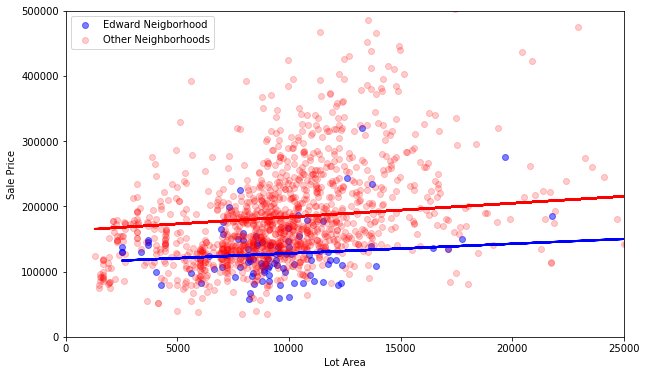

In [68]:
# Visualization code here
plt.figure(figsize=(10,6))

plt.scatter(lot_1, df_edward['SalePrice'],  color='blue', alpha = 0.5, label = 'Edward Neigborhood')
plt.scatter(lot_2, df_NOT_edward['SalePrice'],  color='red', alpha = 0.2, label = 'Other Neighborhoods')

plt.plot(lot_1, pred_1,  color='blue', linewidth=2)
plt.plot(lot_2, pred_2,  color='red', linewidth=2)

plt.ylabel('Sale Price')
plt.xlabel('Lot Area')
plt.xlim([0, 25000])
plt.ylim([0, 500000])
plt.legend();

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [70]:
# code here
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
X_interact = X.copy()
X_interact['interaction'] = X['Neighborhood_Edwards'] * X['LotArea']
baseline = np.mean(cross_val_score(regression, X_interact, y, scoring='r2', cv=crossvalidation))
baseline

0.8093363403933006

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [72]:
# code here
import statsmodels.api as sm
X_interact = sm.add_constant(X_interact)
model = sm.OLS(y,X_interact)
results = model.fit()

results.summary()

/Users/kamileyagci/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/kamileyagci/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/kamileyagci/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/kamileyagci/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/kamileyagci/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value enc

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     129.8
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:59:55   Log-Likelihood:                -17324.
No. Observations:                1460   AIC:                         3.474e+04
Df Residuals:                    1412   BIC:                         3.500e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.814e+04   4500.202      6.254      0.000    1.93e+04     3.7e+04
LotArea                  0.4488      0.109      4.103      0.000       0.234       0.663
1stFlrSF                26.7057      3.448      7.745      0.000      19.942      33.470
GrLivArea               53.2493      2.538     20.982      0.000      48.271      58.228
BldgType_1Fam          2.71e+04   2812.793      9.633      0.000    2.16e+04    3.26e+04
BldgType_2fmCon       1.317e+04   6067.297      2.171      0.030    1270.404    2.51e+04
BldgType_Duplex      -2476.0164   4885.447     -0.507      0.612   -1.21e+04    7107.499
BldgType_Twnhs       -1.031e+04   5939.969     -1.736      0.083    -2.2e+04    1338.319
BldgType_TwnhsE        663.6056   3966.280      0.167      0.867   -7116.829    8444.040
KitchenQual_Ex        5.759e+04   4030.636     14.287      0.000    4.97e+04    6.55e+04
KitchenQual_Fa       -2.417e+04   4857.062     -4.976      0.000   -3.37e+04   -1.46e+04
KitchenQual_Gd        5866.1404   2431.822      2.412      0.016    1095.768    1.06e+04
KitchenQual_TA       -1.114e+04   2288.479     -4.870      0.000   -1.56e+04   -6654.665
SaleType_COD         -1.575e+04   6905.746     -2.280      0.023   -2.93e+04   -2199.120
SaleType_CWD          7858.4610   1.64e+04      0.479      0.632   -2.43e+04       4e+04
SaleType_Con          4.574e+04   2.31e+04      1.978      0.048     378.479    9.11e+04
SaleType_ConLD         778.1770   1.18e+04      0.066      0.948   -2.24e+04     2.4e+04
SaleType_ConLI       -4330.8428   1.48e+04     -0.292      0.770   -3.34e+04    2.48e+04
SaleType_ConLw       -8646.9295   1.49e+04     -0.581      0.561   -3.78e+04    2.05e+04
SaleType_New          1.153e+04   5843.845      1.973      0.049      64.781     2.3e+04
SaleType_Oth         -4543.6133   1.87e+04     -0.243      0.808   -4.13e+04    3.22e+04
SaleType_WD          -4492.3855   4919.425     -0.913      0.361   -1.41e+04    5157.783
MSZoning_C (all)     -1.366e+04   1.12e+04     -1.221      0.222   -3.56e+04    8286.269
MSZoning_FV           1.182e+04   8213.142      1.439      0.150   -4290.647    2.79e+04
MSZoning_RH            493.9610   8413.751      0.059      0.953    -1.6e+04     1.7e+04
MSZoning_RL           9127.0284   4181.274      2.183      0.029     924.852    1.73e+04
MSZoning_RM           2.037e+04   4689.952      4.342      0.000    1.12e+04    2.96e+04
Street_Grvl           1.597e+04   9460.524      1.688      0.092   -2584.183    3.45e+04
Street_Pave           1.217e+04   6512.363      1.869      0.062    -606.242    2.49e+04
Neighborhood_Blmngtn  1.773e+04   9375.329      1.891      0.059    -662.688    3.61e+04
Neighborhood_Blueste  1.098e+04   2.45e+04      0.449      0.653    -3.7e+04     5.9e+04
Neighborhood_BrDale  -9908.8240   1.03e+04     -0.960    

What is your conclusion here?

In [ ]:
# formulate your conclusion
#Selected interaction improved R2 value significantly,  from 0.777 to 0.809. 

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.